# Coursework

Importing all libraries

In [1]:
from typing import List , Tuple

import numpy as np
import tensorflow as tf
import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression as MIR
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

## Data preparation

### Data import

In [2]:
data_file = 'pue.csv'
all_data = np.genfromtxt(data_file, 
                         delimiter=',', 
                         skip_header=1, 
                         skip_footer=5, 
                         dtype=np.float64, # check casting
                         encoding='gb2312')

### Data analysis

This shows how many dimensions can save data (非前64维) variance above 99%

In [3]:
pca = PCA()
pca.fit(all_data[:, 64:-2])
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99)

print(d)

6


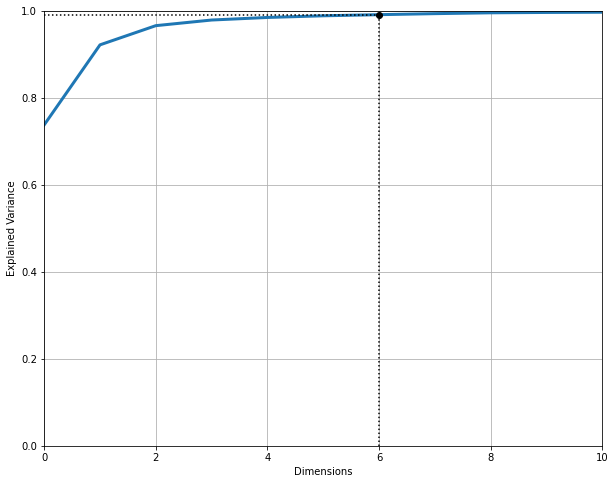

In [4]:
plt.figure(figsize=(10,8))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 10, 0.5, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.991], "k:")
plt.plot([0, d], [0.991, 0.991], "k:")
plt.plot(d, 0.991, "ko")

plt.grid(True)
plt.show()

### Picking features

In [5]:
# x 输入数据
# reduction_components 降维到多少维（2或3）
def pca_reduction(x, reduction_components):
    pca = PCA(n_components = reduction_components) # 降维
    pca.fit(x) # 训练
    newX = pca.fit_transform(x) # 降维后的数据
    
    return newX

In [6]:
# normalize 是否进行归一化
# reduction 是否降维
# select_count 特征选择的个数
# reduction_components 降维到多少维（2或3）
def feature_selection(data, normalize=True, reduction=True, scorefunc='f_regression', select_count=10, reduction_components=2, cast_to_type=None):
    
    # TODO: change into one cycle
    # 数据
    x_64 = data[:, :64].copy().astype(np.float32)                    # 前64维
    x_other = data[:, 64:-2].copy()                                  # 非前64维
    if cast_to_type is not None and type(all_data[0,0]) is not cast_to_type:
        x_other = x_other.astype(cast_to_type)
    y = data[:, -1].copy()                                           # pue 
    time = data[:, -2].copy()                                        # time
    
    # 归一化，所有特征都进行归一化
    if normalize == True:       
        scaler = MinMaxScaler()   
        x_64 = scaler.fit_transform(x_64)
        x_other = scaler.fit_transform(x_other)

    # 特征选择，只对【非前64维度的特征】进行特征选择
    if scorefunc == 'MIR':                      # 互信息回归
        fs = SelectKBest(MIR, k=select_count)
    elif scorefunc == 'f_classif':              # F检验分类
        fs = SelectKBest(score_func=f_classif, k=select_count)
    else:                                       # F检验回归
        fs = SelectKBest(score_func=f_regression, k=select_count)

    X_selected = fs.fit_transform(x_other, y)

    
    # PCA降维
    if reduction == True:
        X_selected = pca_reduction(X_selected, reduction_components)

        
    # 将前64维和处理后的特征拼接在一起
    return np.append(x_64, X_selected, axis=1), y, time

In [7]:
# 结果 = 前64维 + 【非前64维特征】特征选择后的特征

X, Y, time = feature_selection(all_data, reduction=False, select_count=20, cast_to_type=np.float32) 

print(X.shape)
print(Y.shape)
print(time.shape)

(2272, 84)
(2272,)
(2272,)


/Users/Alexey/miniconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/Alexey/miniconda3/envs/deeplearning/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


PUE by time graph

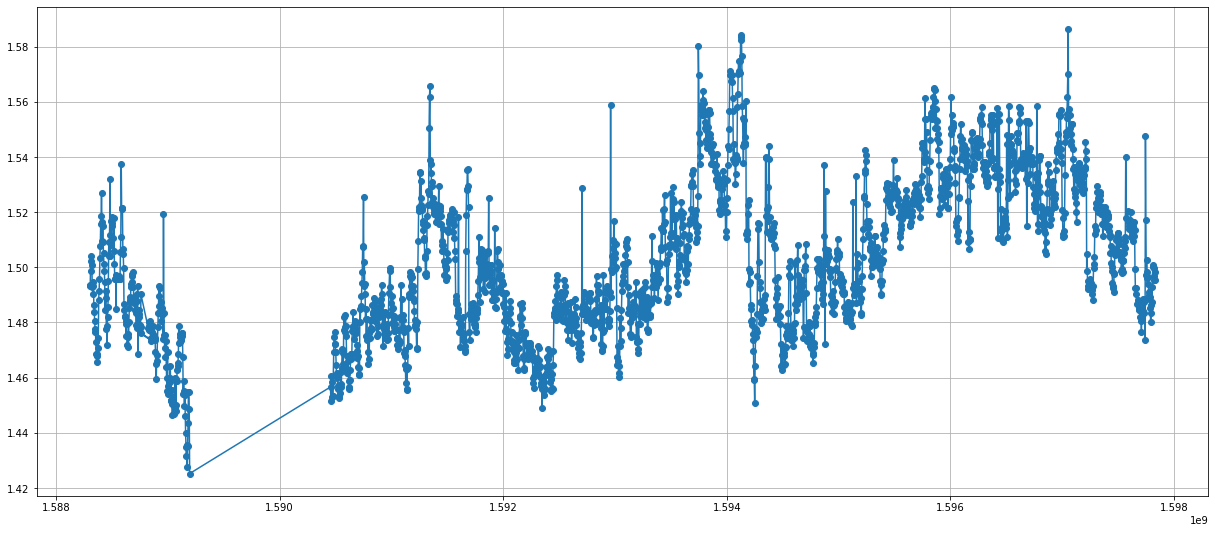

In [8]:
plt.figure(figsize=(21, 9))
plt.plot(time, Y, '-o')
plt.grid(True)

### Data split

In [9]:
split_time = 2048
window_size = 32
batch_size = 64
shuffle_buffer_size = 512

time_train = time[:split_time]
x_train = X[:split_time]
y_train = Y[:split_time]

time_valid = time[split_time:]
x_valid = X[split_time:]
y_valid = Y[split_time:]

x_train = np.expand_dims(x_train, axis=1)
x_valid = np.expand_dims(x_valid, axis=1)
y_train = np.expand_dims(y_train, axis=1)
y_valid = np.expand_dims(y_valid, axis=1)

## Define model

### Actual training

In [14]:
class EndEpochResetState(tf.keras.callbacks.Callback):
    def __init__(self):
        pass
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[None, x_train.shape[-1]], batch_size=32),    
    tf.keras.layers.LSTM(512, return_sequences=True, stateful=True),
    tf.keras.layers.LSTM(256, return_sequences=False, stateful=True),
    tf.keras.layers.Dense(128, activation="elu"),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Nadam()

model.compile(
    loss="mse",
    optimizer=optimizer,
    metrics=["mae"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, None, 512)           1222656   
_________________________________________________________________
lstm_1 (LSTM)                (32, 256)                 787456    
_________________________________________________________________
dense (Dense)                (32, 128)                 32896     
_________________________________________________________________
dense_1 (Dense)              (32, 64)                  8256      
_________________________________________________________________
dense_2 (Dense)              (32, 1)                   65        
Total params: 2,051,329
Trainable params: 2,051,329
Non-trainable params: 0
_________________________________________________________________


In [16]:
epochs = 10
history = model.fit(x_train, y_train, epochs=epochs,
                   validation_data=(x_valid,y_valid),
                    callbacks=[EndEpochResetState()]
                   )

Epoch 1/10
64/64 [==============================] - 2s 34ms/step - loss: 0.0877 - mae: 0.1178 - val_loss: 0.0203 - val_mae: 0.1363
Epoch 2/10
64/64 [==============================] - 2s 26ms/step - loss: 0.0393 - mae: 0.0682 - val_loss: 0.0017 - val_mae: 0.0353
Epoch 3/10
64/64 [==============================] - 2s 26ms/step - loss: 0.0226 - mae: 0.0511 - val_loss: 7.8156e-04 - val_mae: 0.0234
Epoch 4/10
64/64 [==============================] - 2s 26ms/step - loss: 0.0092 - mae: 0.0390 - val_loss: 6.1269e-04 - val_mae: 0.0188
Epoch 5/10
64/64 [==============================] - 2s 26ms/step - loss: 0.0046 - mae: 0.0377 - val_loss: 0.0026 - val_mae: 0.0446
Epoch 6/10
64/64 [==============================] - 2s 25ms/step - loss: 0.0026 - mae: 0.0364 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 7/10
64/64 [==============================] - 2s 25ms/step - loss: 0.0015 - mae: 0.0260 - val_loss: 6.2829e-04 - val_mae: 0.0188
Epoch 8/10
64/64 [==============================] - 2s 26ms/step - loss

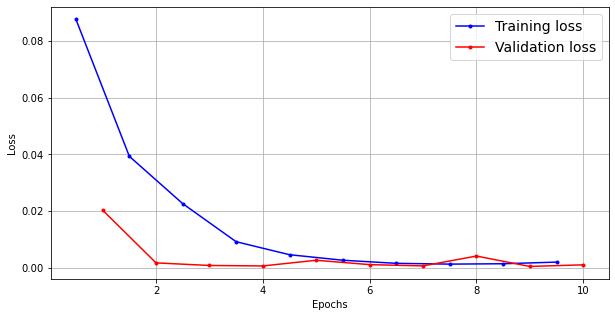

In [17]:
plt.figure(figsize=(10,5))
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Plotting forecast of a trained model

In [18]:
def plot_series(time, series, format="-", start=0, end=None, label=''):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc=3)
    plt.grid(True)

In [19]:
def model_forecast(model, series, window_size=32):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [20]:
# model.reset_metrics()
# rnn_forecast = model_forecast(model, x_valid)
rnn_forecast = model.predict(x_valid)
# rnn_forecast = rnn_forecast[:, 0, 0]

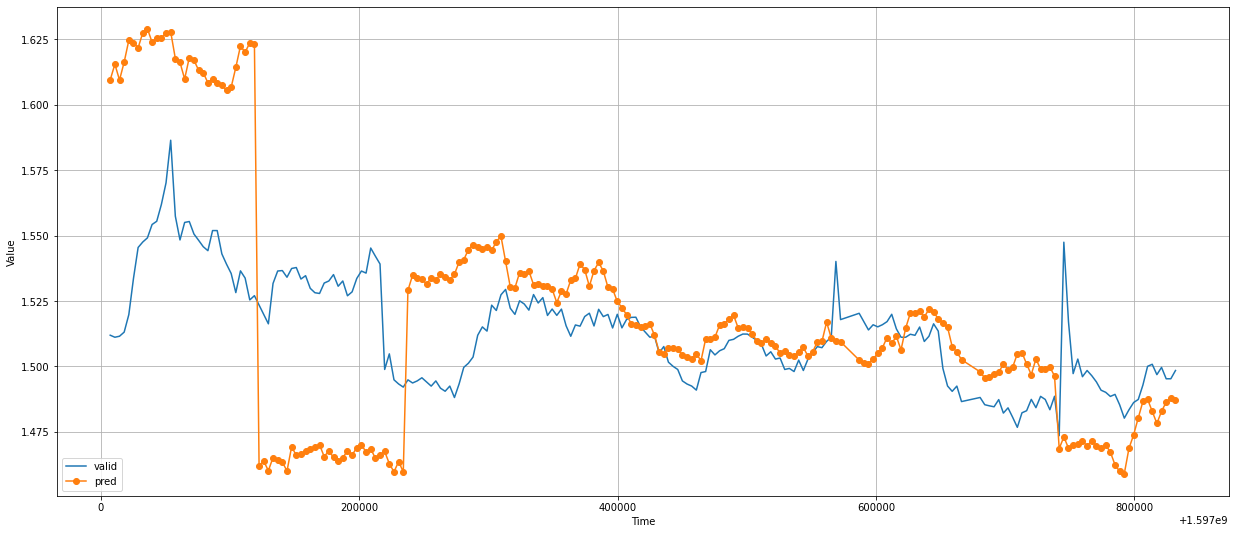

In [21]:
plt.figure(figsize=(21, 9))

# unseen vs 
plot_series(time_valid, y_valid, label='valid')
plot_series(time_valid, rnn_forecast, format='-o', label='pred')

actual mae

In [22]:
np.sum(tf.keras.metrics.mean_absolute_error(y_valid, rnn_forecast))

6.7860637

## Reinforcement Learning
Firstly we create environment (wraper for the LSTM model)

In [23]:
class Environment:
    def __init__(self, model, ideal=1.0, scaler=1000):
        """
            `model`:  tensorflow.keras.model makes predictions
            `ideal`:  is a value we want our environment to return; optimizing to it
            `scaler`: scales reward
        """
        self.model = model
        self.ideal = ideal
        self.scaler = scaler
    
    def _forecast(self, data_series):
        """
            IMPORTANT: Only predicts by batches of 32, current limitation
        """
        return self.model.predict(data_series)
    

    def _calc_reward(self, actual: np.ndarray) -> np.ndarray:
        """
            IMPORTANT: negative of loss. Lower the loss, the better.

            Actually there's no need in abs(), because predicted PUE should 
            always be above 1.0, but such solution should be error resistant.

            returns: numpy.array
        """
        return np.negative(np.abs((actual-self.ideal) * self.scaler))
    
    
    def step(self, action):
        """
            Depricated
        """
        state = self._forecast(action)
        state = np.concatenate([action[:,0], state[:,0]], axis=-1)
        reward = self._calc_reward(pred_val)
        
        return state, reward

    # Wrap as an operation in a TensorFlow function.
    # This would allow it to be included in a callable TensorFlow graph.
    def env_step(self, action: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
            Returns state and reward given an action.
        """
        # state is predicted value
        state = self._forecast(action)
        reward = self._calc_reward(state)
        
        return (state, reward)

    def tf_env_step(self, action: tf.Tensor) -> List[tf.Tensor]:
        return tf.numpy_function(self.env_step, [action], [tf.float32, tf.float32])
    
    def reset(self):
        # TODO: check which to use
        self.model.reset_states()
#         self.model.reset_metrics()
#         keras.backend.clear_session()

    

Then create Actor and Critic

In [24]:
class ActorCritic(tf.keras.Model):
    """Combined actor-critic network."""

    def __init__(self, 
                 num_actions: int, 
                 num_hidden_units: int = 128,
                 n_layers: int = 1,
                 use_alpha_dropout: bool = True):
        """Initialize."""
        
        super().__init__()
        self.n_layers = n_layers
        self.use_alpha_dropout = use_alpha_dropout
        self.common = tf.keras.layers.Dense(num_hidden_units, activation="elu", 
                                            kernel_initializer="lecun_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(0.01)
                                           )
        self.hidden = [(tf.keras.layers.Dense(num_hidden_units, activation="selu", kernel_initializer="lecun_normal"),
                        tf.keras.layers.AlphaDropout(0.2)) 
                       for _ in range(n_layers)
                      ]
        
        self.actor = tf.keras.layers.Dense(num_actions)

        self.critic = tf.keras.layers.Dense(1)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        x = self.common(inputs)
        
        for layer in self.hidden:
            x = layer[0](x)
            if self.use_alpha_dropout:
                x = layer[1](x)

        return self.actor(x), self.critic(x)

In [25]:
def run_episode(
    initial_state: tf.Tensor,  
    agent: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:
    """Runs a single episode to collect training data."""
#     print("------ RUN EPISODE ------")
    actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    values  = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, infer_shape=False)

    initial_state_shape = initial_state.shape
    state = initial_state

    
    for t in tf.range(max_steps):
        # Run the model and to get action probabilities and critic value
        tf.debugging.assert_all_finite(state, message="state fed into agent has problems")
        action, value = agent(state)
        tf.debugging.assert_all_finite(value, message="value received from agent has problems")
        tf.debugging.assert_all_finite(action, message="action received from agent has problems")

        # Store critic values
        values = values.write(t, tf.squeeze(value))

        # Store log of the action chosen
        actions = actions.write(t, action)

        # Apply action to the environment to get next state and reward
        pred_state, reward = env.tf_env_step(tf.expand_dims(action, 1))

        state = tf.concat([tf.squeeze(action), pred_state], 1)

        state.set_shape(initial_state_shape)
        reward.set_shape(initial_state.shape[0:1])
        tf.squeeze(reward)

        # Store reward
        rewards = rewards.write(t, reward)


    actions = actions.concat()
    values = values.concat()
    rewards = rewards.concat()
    
    return actions, values, rewards

In [26]:
# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
    """Compute expected returns per timestep."""

    n = tf.shape(rewards)[0] # num of steps * batch size = 2048

    returns = tf.TensorArray(dtype=tf.float32, size=n, infer_shape=False)

    # Start from the end of `rewards` and accumulate reward sums
    # into the `returns` array
    discounted_sum = tf.constant(0.0)
    discounted_sum_shape = discounted_sum.shape

    for i in tf.range(n):
        reward = rewards[i]
        discounted_sum = reward + gamma * discounted_sum
        discounted_sum.set_shape(discounted_sum_shape)
        returns = returns.write(i, discounted_sum)
    
    returns = returns.concat()

    if standardize:
        returns = ((returns - tf.math.reduce_mean(returns)) / 
                   (tf.math.reduce_std(returns) + eps))


    return returns

In [27]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    actions: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
    """Computes the combined actor-critic loss."""

#     advantage = returns - values
#     tf.debugging.assert_all_finite(advantage, message="actions has problems")
    

    # Reciprocal of variance of taken actions ->
    # encourages agent to take have more variance 
    # and its influence is normalized by actual returns.
    # So now agent can see if high variance leads to good results.
    # And initial higher variance leads to better space exploration.
    # Lower variance, on the other hand, improves convergence speed, 
    # but not necessarily to the best answer.
    
#     tf.debugging.assert_all_finite(actions, message="actions has problems")
#     actions_log = tf.clip_by_value(tf.math.reduce_variance(actions, -1), 
#                                    clip_value_min=0, clip_value_max=5e4
#                                   )
#     tf.debugging.assert_all_finite(actions_log, message="actions_log has problems")

#     actor_loss = tf.math.reduce_sum(actions_log * tf.abs(returns))
#     tf.debugging.assert_all_finite(actor_loss, message="actor_loss has problems")

    critic_loss = huber_loss(values, returns)
    tf.debugging.assert_all_finite(critic_loss, message="critic_loss has problems")
    
    return critic_loss + tf.reduce_sum(tf.abs(returns))

In [28]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

@tf.function
def train_step(
    initial_state: tf.Tensor, 
    agent: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
    """
        Runs a model training step.
    """

    with tf.GradientTape() as tape:

        # Run the model for one episode to collect training data
        actions, values, rewards = run_episode(initial_state, agent, max_steps_per_episode)
    
        # Calculate expected returns
        returns = get_expected_return(rewards, gamma)
        # Convert training data to appropriate TF tensor shapes
        actions, values = [tf.expand_dims(x, 1) for x in [actions, values]] 
        # Calculating loss values to update our network
        loss = compute_loss(actions, values, returns)
    
    # Compute the gradients from the loss
    tf.debugging.assert_all_finite(loss, message="loss has problems")
    grads = tape.gradient(loss, agent.trainable_variables)

    # Apply the gradients to the model's parameters
    optimizer.apply_gradients(zip(grads, agent.trainable_variables))
    episode_reward = tf.math.reduce_sum(rewards)

    return episode_reward, loss

And finally start optimizing on the environment


In [33]:
%%time

n_episodes = 100_000
n_steps = 64
num_actions = model.input_shape[2]
num_hidden_units = 128

initial_state = np.concatenate([x_train[1:33,0], y_train[:32]], axis=-1)
initial_state = initial_state.astype(np.float32)

env = Environment(model, scaler=1)
actorCriticModel = ActorCritic(num_actions, num_hidden_units, n_layers=1, use_alpha_dropout=True)

# consecutive trials
reward_threshold = -200
running_reward = 0

# Discount factor for future rewards
gamma = 0.9998
history = []

with tqdm.trange(n_episodes) as t:
    for i in t:
        env.reset()
        initial_state = np.concatenate([x_train[1:33,0], y_train[:32]], axis=-1)
        initial_state = initial_state.astype(np.float32)
        episode_reward_, loss = train_step(initial_state, actorCriticModel, optimizer, gamma, n_steps)
        tf.debugging.assert_all_finite(episode_reward_, message="running reward has problems")
        episode_reward = int(episode_reward_)
        running_reward = episode_reward*0.01 + running_reward*.99
        history.append(episode_reward)
        t.set_description(f'Episode {i}')
        t.set_postfix(episode_reward=episode_reward, running_reward=running_reward, loss=loss.numpy())


        if running_reward > reward_threshold and i > 30:
            break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 10229:  10%|█         | 10230/100000 [5:23:22<47:17:37,  1.90s/it, episode_reward=-1080, loss=1.76e+3, running_reward=-1.08e+3]


KeyboardInterrupt: 

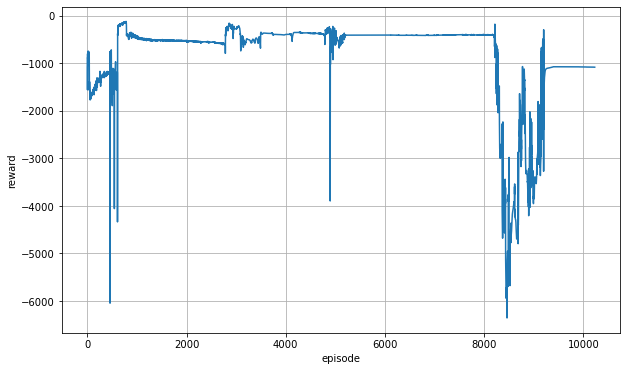

In [34]:
plt.figure(figsize=(10,6))
plt.plot(history)
plt.xlabel("episode")
plt.ylabel("reward")

plt.grid(True)

In [35]:
actorCriticModel.summary()

Model: "actor_critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  11008     
_________________________________________________________________
dense_4 (Dense)              multiple                  16512     
_________________________________________________________________
alpha_dropout (AlphaDropout) multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  10836     
_________________________________________________________________
dense_6 (Dense)              multiple                  129       
Total params: 38,485
Trainable params: 38,485
Non-trainable params: 0
_________________________________________________________________


In [37]:
actorCriticModel.save("agent_model")

INFO:tensorflow:Assets written to: agent_model/assets


## Debuging part

In [29]:
# for z in tf.range(1):
#     state = initial_state
#     rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
#     actions = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
#     values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

#     for t in tf.range(64):
#         action, value = actorCriticModel(state)
#         pred, reward = env.tf_env_step(x_train[1:33])
#         values = values.write(t, tf.squeeze(value))
#         actions = actions.write(t, action)
#         rewards = rewards.write(t, tf.squeeze(reward))
#         state = tf.concat([tf.squeeze(action), tf.squeeze(pred, 1)], 1)
#         state.set_shape(initial_state.shape)
    
#     values = values.concat()
#     actions = actions.concat()
#     rewards = rewards.concat()

#     tf.print(rewards)
#     n1 = tf.shape(rewards)[0] # num of episodes = 10

    
#     returns = tf.TensorArray(dtype=tf.float32, size=n1)
 
#     discounted_sum = tf.constant(0.0)
#     discounted_sum_shape = discounted_sum.shape

#     for i in tf.range(n1):
#         reward = rewards[i]
#         discounted_sum = reward + gamma * discounted_sum
#         discounted_sum.set_shape(discounted_sum_shape)
#         returns = returns.write(i, discounted_sum)

# #     print("returns shape", returns.element_shape)
#     returns = returns.stack()
# #     print("## returns shape", returns.shape)
#     returns = ((returns - tf.math.reduce_mean(returns)) / (tf.math.reduce_std(returns) + eps))
    

# #     print("mean returns", returns)
    
#     actions, values, returns = [tf.expand_dims(x, 1) for x in [actions, values, returns]] 

# #     tf.print(actions.shape)
# #     tf.print(actions)
# #     tf.print(returns.shape)
# #     tf.print(values.shape)
#     advantage = returns - values
# #     print("advantage shape:", advantage.shape)
# #     print("advantage:", advantage)
# #     tf.math.reduce_variance)
# #     print("actions shape", actions.shape)
# #     print("actions shape", actions)
#     actions_log = tf.math.reduce_variance((actions + eps), -1)

#     print("actions_log")
#     tf.print(actions_log.shape)
#     tf.print(actions_log)
#     tf.print(tf.math.reduce_sum(actions_log))
#     print("----------------")
#     print("returns")
#     tf.print(returns.shape)
#     tf.print(returns)
#     tf.print(tf.math.reduce_sum(tf.abs(returns)))
#     print("----------------")
#     actor_loss = tf.math.reduce_sum(actions_log * tf.abs(returns))
#     print("actor loss", actor_loss)
#     critic_loss = huber_loss(values, returns)
#     print("critic loss", critic_loss)
#     #     print("actor loss:", int(actor_loss), "critic loss:", int(critic_loss))
#     loss = actor_loss + critic_loss
#     print("-> total loss", loss.numpy())

#     print(int(tf.math.reduce_sum(rewards)))

In [30]:
# import contextlib

# @contextlib.contextmanager
# def options(options):
#   old_opts = tf.config.optimizer.get_experimental_options()
#   tf.config.optimizer.set_experimental_options(options)
#   try:
#     yield
#   finally:
#     tf.config.optimizer.set_experimental_options(old_opts)

In [31]:
# print(tf.config.optimizer.get_experimental_options())
# # tf.config.threading.set_inter_op_parallelism_threads(1)

In [32]:
# with options({ 'disable_model_pruning':True, 'disable_meta_optimizer': True}):
#     print(tf.config.optimizer.get_experimental_options())
#     train_step(
#         initial_state, 
#         actorCriticModel, 
#         optimizer,
#         gamma, 
#         n_episodes
#     )